# Import library

In [3]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import datasketch   
from tqdm import tqdm

import nltk

In [4]:
print(os.getcwd())
path = os.path.abspath(os.path.join(os.getcwd(), "../data"))
print(path)
# data_train = pd.read_csv(path + '/train.csv')
data = pd.read_csv(path + '/train.csv',index_col='id')


/Users/yusuke_sugihara/DA_Project1/DataAnalytics/Quora-question-pair-similarity
/Users/yusuke_sugihara/DA_Project1/DataAnalytics/data


# Preprocessing and Exploratory Data Analysis(Simple ver.)

In [5]:
print(data.shape)
print(data.head())

(404290, 5)
    qid1  qid2                                          question1  \
id                                                                  
0      1     2  What is the step by step guide to invest in sh...   
1      3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2      5     6  How can I increase the speed of my internet co...   
3      7     8  Why am I mentally very lonely? How can I solve...   
4      9    10  Which one dissolve in water quikly sugar, salt...   

                                            question2  is_duplicate  
id                                                                   
0   What is the step by step guide to invest in sh...             0  
1   What would happen if the Indian government sto...             0  
2   How can Internet speed be increased by hacking...             0  
3   Find the remainder when [math]23^{24}[/math] i...             0  
4             Which fish would survive in salt water?             0  


In [6]:
print(data.sample(10, random_state=42))

          qid1    qid2                                          question1  \
id                                                                          
8067     15738   15739                 How do I play Pokémon GO in Korea?   
368101   12736  104117  What are some of the best side dishes for crab...   
70497   121486  121487  Which is more advisable and better material fo...   
226567  254474  258192       How do I improve logical programming skills?   
73186    48103    3062             How close we are to see 3rd world war?   
215105  177688   83888   What do Chinese people think about Donald Trump?   
253209  367707  153452    How many hours a week do Google employees work?   
354651  483796   11244  How can we follow a Quora question privately w...   
104478  172497  172498                    Why are cats so overprotective?   
163628  254474  254475       How do I improve logical programming skills?   

                                                question2  is_duplicate  
i

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404290 entries, 0 to 404289
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          404290 non-null  int64 
 1   qid2          404290 non-null  int64 
 2   question1     404289 non-null  object
 3   question2     404288 non-null  object
 4   is_duplicate  404290 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 18.5+ MB


In [8]:
data[data.isnull().any(axis=1)]

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
105780,174363,174364,How can I develop android app?,NaN,0
201841,303951,174364,How can I create an Android app?,NaN,0
363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [9]:
data = data.dropna(how="any").reset_index(drop=True)
data.shape

(404287, 5)

In [10]:
data['is_duplicate'].value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

<Axes: ylabel='count'>

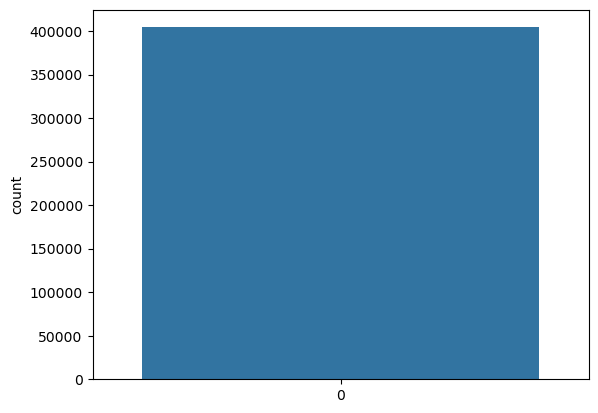

In [11]:
sns.countplot(data['is_duplicate'])

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
# data_train = data_train.sample(2000, random_state=10)

X = data[['question1', 'question2']]
y = data['is_duplicate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train = X_train[:1000]
y_train = y_train[:1000]
# print(data.head())
print(X_train.head())
print(X_train.shape)
print(y_train.head())
print(y_train.shape)
print(X_test.shape)

                                                question1  \
140907  What is the new method of angioplasty which co...   
107095  On WhatsApp, it says on the message info that ...   
27940   How do the holy scriptures of Hinduism compare...   
157099  How long does it typically take to get a pilot...   
111381  My questions haven't changed. Why are they now...   

                                                question2  
140907           How much does it cost to run a hospital?  
107095  My friend is abroad and I have sent him messag...  
27940   How do the holy scriptures of Hinduism compare...  
157099  How much does it cost to get a private pilots ...  
111381  What should I do if my question is being marke...  
(1000, 2)
140907    0
107095    0
27940     0
157099    0
111381    1
Name: is_duplicate, dtype: int64
(1000,)
(121287, 2)


In [13]:
com_data_train = X_train['question1'].append(X_train['question2']).reset_index()
print(com_data_train.head())


    index                                                  0
0  140907  What is the new method of angioplasty which co...
1  107095  On WhatsApp, it says on the message info that ...
2   27940  How do the holy scriptures of Hinduism compare...
3  157099  How long does it typically take to get a pilot...
4  111381  My questions haven't changed. Why are they now...


/var/folders/11/4w81_8697d9g_9c3944_ytwh0000gn/T/ipykernel_79130/3115984954.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  com_data_train = X_train['question1'].append(X_train['question2']).reset_index()


In [14]:
com_data_train.drop(['index'],axis=1,inplace=True)
com_data_train.columns = ['question']
print(com_data_train.head())

                                            question
0  What is the new method of angioplasty which co...
1  On WhatsApp, it says on the message info that ...
2  How do the holy scriptures of Hinduism compare...
3  How long does it typically take to get a pilot...
4  My questions haven't changed. Why are they now...


In [15]:
print(com_data_train.shape)

(2000, 1)


## Making a dictionary mapping a question to its duplicate question

In [16]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from datasketch import MinHash, MinHashLSH
from tqdm import tqdm

In [17]:
# Create a dictory of all dupllcated questions.
correct = X_train[y_train==1]
correct_dict = {}
for x,y in zip(correct['question1'],correct['question2']):
    if correct_dict.get(x)==None:
        correct_dict[x] = [y]
    else:
        correct_dict[x].append(y)
        correct_dict[x] = [i for i in set(correct_dict[x])]
for x,y in zip(correct['question2'],correct['question1']):
    if correct_dict.get(x)==None:
        correct_dict[x] = [y]
    else:
        correct_dict[x].append(y)
        correct_dict[x] = [i for i in set(correct_dict[x])]

## Set Representation

In [18]:
set_dict={} # maps question to set representation of question
norm_dict={} # maps question id (eg 'm1') to actual question. We may use this dictionary to evaluate results of LSH output.
count=1

for question in tqdm([x for x in com_data_train['question'] if type(x)==str]):
    temp_list = []
    for shingle in question.split(' '): # shingle is a word
        if shingle not in stop_words:
            temp_list.append(shingle.lower())
    set_dict["m{}".format(count)] = set(temp_list)
    norm_dict["m{}".format(count)] = question
    count +=1

100%|██████████| 2000/2000 [00:00<00:00, 192306.64it/s]


In [19]:
set_dict['m1']

{'5000/-',
 'angioplasty',
 'blockage?',
 'costs',
 'hospital',
 'j',
 'method',
 'mumbai',
 'new',
 'removal',
 'rs.',
 'what'}

In [20]:
norm_dict['m1']

'What is the new method of angioplasty which costs Rs. 5000/- at J J Hospital Mumbai for removal of blockage?'

In [21]:
# set_dict.values()

## Create minHash signatures

In [22]:
num_perm = 10
min_dict = {} # maps question to "min hash signatures"
count2 = 1
for val in tqdm (set_dict.values()): 
    m = MinHash(num_perm=num_perm)
    for shingle in val:
        m.update(shingle.encode('utf8'))
    min_dict["m{}".format(count2)] = m
    count2+=1
print(min_dict['m1'].hashvalues)

100%|██████████| 2000/2000 [00:00<00:00, 4555.56it/s]

[ 115315364   40757083  480571076  499784847  124208477   39501873
  657872351 1836235947  245478683   43240855]


In [23]:
# # toy example

# set1 = set(['minhash', 'is', 'a', 'probabilistic', 'data', 'structure', 'for',
#             'estimating', 'the', 'similarity', 'between', 'datasets'])
# set2 = set(['minhash', 'is', 'a', 'probability', 'data', 'structure', 'for',
#             'estimating', 'the', 'similarity', 'between', 'documents'])
# set3 = set(['minhash', 'is', 'probability', 'data', 'structure', 'for',
#             'estimating', 'the', 'similarity', 'between', 'documents'])

# m1 = MinHash(num_perm=10)
# m2 = MinHash(num_perm=10)
# m3 = MinHash(num_perm=10)
# for d in set1:
#     m1.update(d.encode('utf8'))
# print(m1.hashvalues)
# for d in set2:
#     m2.update(d.encode('utf8'))
# for d in set3:
#     m3.update(d.encode('utf8'))


## Create LSH index

In [24]:
lsh = MinHashLSH(threshold=0.6, num_perm=num_perm)
for key in tqdm(min_dict.keys()):
    lsh.insert(key,min_dict[key])

100%|██████████| 2000/2000 [00:00<00:00, 142704.66it/s]


In [25]:
def create_cand_pairs():
    big_list = []
    for query in min_dict.keys():
        bucket = lsh.query(min_dict[query])
        if len(bucket)==1:
            big_list.append([bucket[0],"None"])
        if len(bucket)>1:
            first_val = bucket[0]
            for val in bucket[1:]:
                second_val = val
                big_list.append([first_val,second_val])
    return big_list

In [26]:
cand_pairs = create_cand_pairs()
print(cand_pairs[:10])

[['m1', 'None'], ['m1002', 'm2'], ['m3', 'None'], ['m4', 'None'], ['m5', 'None'], ['m6', 'None'], ['m7', 'None'], ['m8', 'm1008'], ['m9', 'None'], ['m10', 'None']]


In [27]:
def evaluation(cand_pairs):
    tp = 0 # true positive
    fp = 0 # false positive
    fn = 0 # false negatives
    for pair in cand_pairs:
        if pair[1] == "None":
            if str(norm_dict[pair[0]]) in correct_dict.keys():
                    fn +=1
        else:
            if isinstance(correct_dict.get(norm_dict[pair[0]]), (list,)):
                if norm_dict[pair[1]] in correct_dict.get(norm_dict[pair[0]]):
                    tp +=1
                else:
                    fp +=1
                    
    precision = tp/(fp+tp)
    recall = tp/(fn+tp)
    print ('precision is {:.2f}'.format(precision))
    print ('recall is {:.2f}'.format(recall))

In [28]:
evaluation(cand_pairs)

precision is 0.33
recall is 0.38
